# AUTOMATING NDVI FOR LANDSAT 8 AND SENTINEL 2

## Importing necessary libraries

In [ ]:
import numpy as np
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import rasterio
import matplotlib.pyplot as plt
import folium
from rasterio import plot
from glob import glob
%matplotlib inline

## Sentinel 2

SENTINEL-2 is a wide-swath, high-resolution, multi-spectral imaging mission launched in June 2015 by the Copernicus programme of the European Commision. It consists of two twin satellites (Sentinel 2a & 2b) flying in the same orbit but phased at 180°, designed to give a high revisit frequency of 5 days at the Equator. SENTINEL-2 carries an optical instrument payload that samples 13 spectral bands: four bands at 10 m, six bands at 20 m and three bands at 60 m spatial resolution. The orbital swath width is 290 km

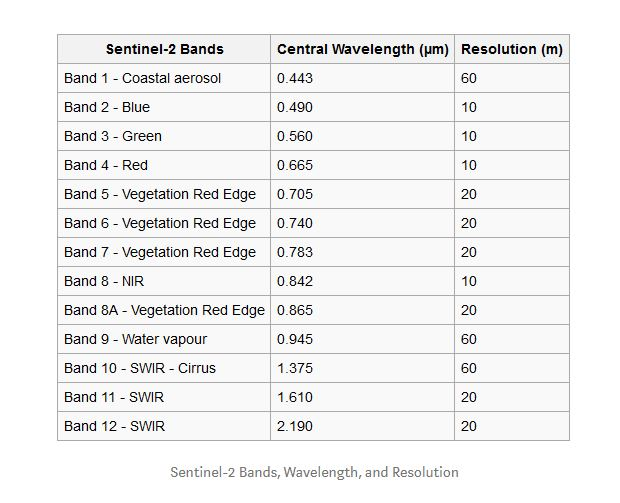

###### Step 1 (Optional): Displaying study area with Folium

In [ ]:
# If available read in shapefile of study area to view on folium

# Pass in the path of the shapefile on your local machine
shapefile = gpd.read_file('')

# To display on folium you need to pass in the latitude & longitude of the study area
# Assign the latitude & longitude values of study area to the latitude and longitude variables and run the cell
latitude = 
longitude = 

# Instantiating folium with latitude and longitude defined
study_map = folium.Map([latitude, longitude], zoom_start=11)

# Adding shapefile to folium instance
folium.GeoJson(shapefile).add_to(study_map)

# Display study area map
study_map

###### Step 2: Generating True Color Composite (RGB Image) for Sentinel 2

Sentinel 2 images are categorized based on their spatial resolution once downloaded. Both Bands 4 and 8 have a spatial resolution of 10m, hence both bands would be available in the '../R10m' folder after the image has been unzipped. An example is given in the cell below. Sentinel 2 images are made available in raster format and to access this the rasterio library can be employed

*Note: For easier access, the tab key can be used to autocomplete folder names and avoid errors when reading in the data*

i.e reading in band 4 would look like this: 
'C:/Users/User/Desktop/S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/GRANULE/L2A_T33TTG_A011731_20190605T100530/IMG_DATA/R10m/T33TTG_20190605T100039_B04_10m.jp2'

In [ ]:
# The context manager and rasterio library can be employed to generate the RGB image
# In generating true color composite we utilize the bands within the visible spectrum i.e Red, Blue and Green bands
# Referencing the sentinel 2 table above we see that Blue, Green and Red bands are given as Bands 2,3 and 4 respectively

# First read in the path of the bands into the variables band2, band3 and band4, such that each veariable represents each band
band2 = rasterio.open('')
band3 = rasterio.open('')
band4 = rasterio.open('')

In [ ]:
# Creating three axes to display each RGB band
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12,6))

# Displaying Band 2 (Blue)
plot.show(band2, ax=ax1, cmap='Blues')
ax1.set_title('Band 2 (Blue)')

# Displaying Band 3 (Green)
plot.show(band3, ax=ax2, cmap='Greens')
ax2.set_title('Band 3 (Green)')

# Displaying Band 4 (Red)
plot.show(band4, ax=ax3, cmap='Reds')
ax3.set_title('Band 4 (Red)')

plt.tight_layout()

In [ ]:
# Generating RGB (True color composite) image with rasterio
# Note: Once you run this code the RGB image saves in your current working directory
# To confirm your current working directory you can run the code 'pwd' in a cell
with rasterio.open('RGB.tiff', 'w', driver='Gtiff', width=band4.width, height=band4.height,
             count=3,crs=band4.crs,transform=band4.transform,dtype=band4.dtypes[0]) as rgb:
    rgb.write(band2.read(1),3)
    rgb.write(band3.read(1),2)
    rgb.write(band4.read(1),1)
    rgb.close()

In [ ]:
# Displaying True color Composite
plt.figure(figsize=(12,8))
plot.show(RGB, cmap='coolwarm')

In [ ]:
# Plotting histogram values
plot.show_hist(RGB, bins=50, stacked=False, lw=0.0, alpha=0.3, histtype='stepfilled', title='Histogram')

###### Step 3: Exploring Band 4 (Red) and 8 (NIR) Properties for NDVI

In [ ]:
# Read in path of red and NIR bands from local machine into band4 and band8 variables
band4 = rasterio.open('')
band8 = rasterio.open('')

In [ ]:
# To check the number of rows and columns in our bands we call the height and width attributes of our bands
# Number of rows of each band
print(band4.height)
print(band8.height)

In [ ]:
# Number of columns of each band
print(band4.width)
print(band8.width)

In [ ]:
# Band types
print(band4.dtypes[0])
print(band8.dtypes[0])

# If the band type shows 'uint16', it should be noted, we would explore further about the band type in a later step

In [ ]:
# Coordinate Reference System of bands
print(band4.crs)
print(band8.crs)

In [ ]:
# Digital numbers of band 4
band4.read(1)

In [ ]:
# Digital numbers of band 8
band8.read(1)

###### Step 4: Displaying Red (Band 4) and NIR (Band 8) Bands with Rasterio and Matplotlib

In [ ]:
# Creating two axes to display each band on an axis
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))

# Displaying band 4 on first axis
plot.show(band4, ax=ax1, cmap='summer')
ax1.set_title('Band 4 (Red)')

# Displaying band 8 on second axis
plot.show(band8, ax=ax2, cmap='summer')
ax2.set_title('Band 8 (NIR)')

plt.tight_layout()

# Notice how Band 8 has a higher reflection, this is because vegetation reflects near-infrared energy
# Band 4 reflects lighter because it is the Red band and vegetation absorbs blue and red light energy to fuel photosynthesis and create chlorophyll 

###### Step 5: Calculating for NDVI

In [ ]:
# Earlier when exploring the attribute of our bands, we saw that both band 4 and 8 have 'uint16' as their dtypes
# When calculating for NDVI these values should be converted to float

# Converting band4 and band8 to float and reassigning them to red and nir variables 
red = band4.read(1).astype('float')
nir = band8.read(1).astype('float')

We may have pixels that hold no value within our bands, calculating NDVI with these pixels may yield some errors. In order to handle these errors we create a conditional statement, where if the the sum of both red and nir bands yield 0, the value should be assigned as 0, otherwise, calculate the NDVI.

In [ ]:
# Creating conditional statement and calculating for NDVI
ndvi = np.where((nir+red)==0.,0, (nir-red)/(nir+red))

# Display NDVI matrix values
ndvi

In [ ]:
# Generating NDVI with Rasterio library
# Note: Once you run this code the NDVI image saves in your current working directory
# To confirm your current working directory you can run the code 'pwd' in a cell
with rasterio.open('NDVI.tiff', 'w',driver='Gtiff', width=band4.width, height=band4.height,
              transform=band4.transform, dtype='float64',count=1, crs=band4.crs) as ndvi_calc:
    ndvi_calc.write(ndvi,1)

###### Step 6: Displaying NDVI

In [ ]:
plt.figure(figsize=(15,10))

# Reading in NDVI image
new_ndvi = rasterio.open('NDVI.tiff')

# Display NDVI image
plot.show(new_ndvi)

###### Step 7: Interpreting NDVI Image

###### Step 8: Clipping Study Area from Satellite Tile

## Landsat 8

Landsat 8 is an American Earth observation satellite launched on 11 February 2013. It is the eighth satellite in the Landsat program and the seventh to reach orbit successfully. Originally called the Landsat Data Continuity Mission (LDCM), it is a collaboration between NASA and the United States Geological Survey (USGS). It comprises of two payloads; the camera of the Operational Land Imager (OLI) and the Thermal Infrared Sensor (TIRS) which can be used to study earth surface temperature and is used to study global warming. The satellite has a temporal resolution of 16 days.

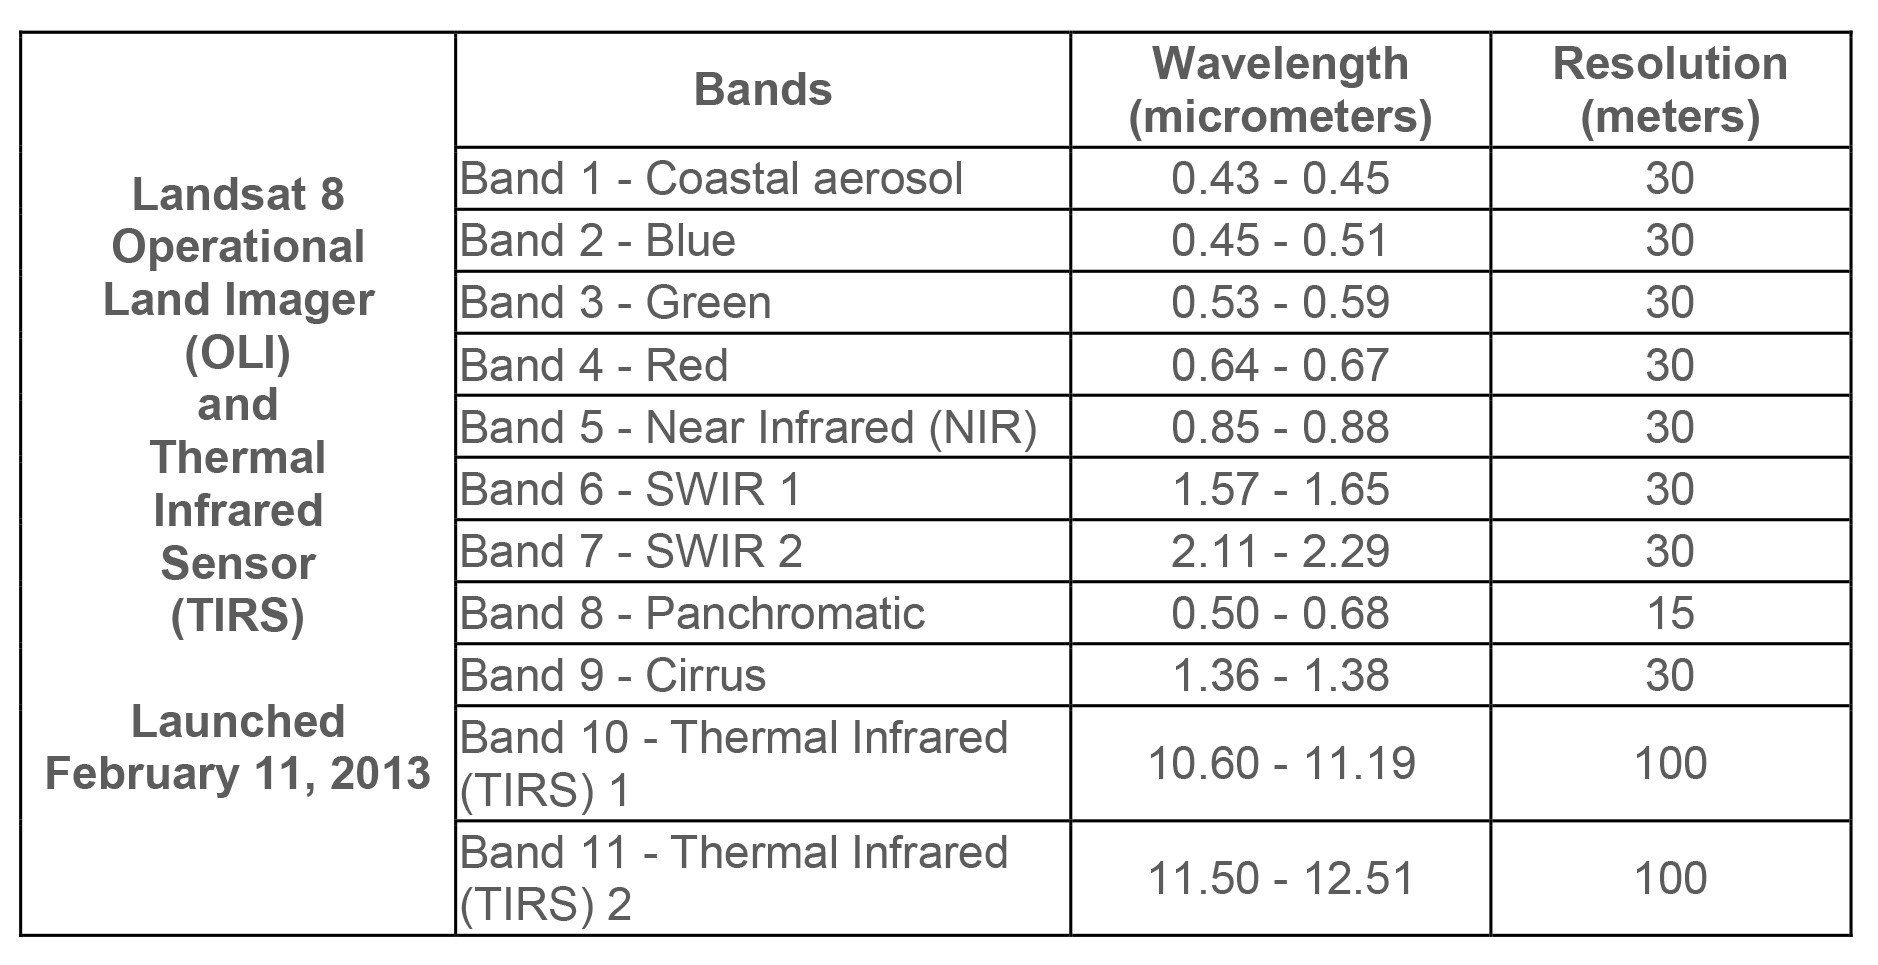

###### Step 1: Reading in paths of necessary bands for NDVI and True Color Composite

In [ ]:
# read in path of band 4 & 5 landsat 8 images on your local machine into the empty strings & run the entire script
band2 = rasterio.open('')
band3 = rasterio.open('')
band4 = rasterio.open('')
band5 = rasterio.open('')

###### Step 2: Generating True Color Composite (RGB Image) for Landsat 8

In [ ]:
# Creating three axes to display each RGB band
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3, figsize=(12,6))

# Displaying Band 2 (Blue)
plot.show(band2, ax=ax1, cmap='Blues')
ax1.set_title('Band 2 (Blue)')

# Displaying Band 3 (Green)
plot.show(band3, ax=ax2, cmap='Greens')
ax2.set_title('Band 3 (Green)')

# Displaying Band 4 (Red)
plot.show(band4, ax=ax3, cmap='Reds')
ax3.set_title('Band 4 (Red)')

plt.tight_layout()

In [ ]:
# Generating RGB (True color composite) image with rasterio
# Note: Once you run this code the RGB image saves in your current working directory
# To confirm your current working directory you can run the code 'pwd' in a cell
with rasterio.open('RGB.tiff', 'w', driver='Gtiff', width=band4.width, height=band4.height,
             count=3,crs=band4.crs,transform=band4.transform,dtype=band4.dtypes[0]) as rgb:
    rgb.write(band2.read(1),3)
    rgb.write(band3.read(1),2)
    rgb.write(band4.read(1),1)
    rgb.close()

In [ ]:
# Displaying True color Composite
plt.figure(figsize=(12,8))
plot.show(RGB, cmap='coolwarm')

In [ ]:
# Plotting histogram values
plot.show_hist(RGB, bins=50, stacked=False, lw=0.0, alpha=0.3, histtype='stepfilled', title='Histogram')

###### Step 3: Exploring Band 4 (Red) and 5 (NIR) Properties for NDVI

In [ ]:
# To check the number of rows and columns in our bands we call the height and width attributes of our bands
# Number of rows of each band
print(band4.height)
print(band5.height)

In [ ]:
# Number of columns of each band
print(band4.width)
print(band5.width)

In [ ]:
# Band types
print(band4.dtypes[0])
print(band5.dtypes[0])

# If the band type shows 'uint16', it should be noted, we would explore further about the band type in a later step

In [ ]:
# Coordinate Reference System of bands
print(band4.crs)
print(band5.crs)

In [ ]:
# Digital numbers of band 4
band4.read(1)

In [ ]:
# Digital numbers of band 4
band5.read(1)

###### Step 4: Displaying Red (Band 4) and NIR (Band 5) Bands with Rasterio and Matplotlib

In [ ]:
# Creating two axes to display each band on an axis
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))

# Displaying band 4 on first axis
plot.show(band4, ax=ax1, cmap='summer')
ax1.set_title('Band 4 (Red)')

# Displaying band 8 on second axis
plot.show(band5, ax=ax2, cmap='summer')
ax2.set_title('Band 5 (NIR)')

plt.tight_layout()

# Notice how Band 5 has a higher reflection, this is because vegetation reflects near-infrared energy
# Band 4 reflects lighter because it is the Red band and vegetation absorbs blue and red light energy to fuel photosynthesis and create chlorophyll 

###### Step 5: Calculating for NDVI

To utilize landsat 8 satellite image for Normalized Difference Vegetation Index (NDVI) we make use of the red and near-infrared bands i.e Band 4 (Red Band) and Band 5 (Near-Infrared Band). We can repeat the same process for Landsat 8, however, Red is given as Band 4 while NIR is given as Band 5.

In [ ]:
# Earlier when exploring the attribute of our bands, we saw that both band 4 and 5 have 'uint16' as their dtypes
# When calculating for NDVI these values should be converted to float

# Converting band4 and band5 to float and reassigning them to red and nir variables 
red = band4.read(1).astype('float')
nir = band5.read(1).astype('float')

We may have pixels that hold no value within our bands, calculating NDVI with these pixels may yield some errors. In order to handle these errors we create a conditional statement, where if the the sum of both red and nir bands yield 0, the value should be assigned as 0, otherwise, calculate the NDVI.

In [ ]:
# Creating conditional statement and calculating for NDVI
ndvi = np.where((nir+red)==0.,0, (nir-red)/(nir+red))

# Display NDVI matrix values
ndvi

In [ ]:
# Generating NDVI with Rasterio library
# Note: Once you run this code the NDVI image saves in your current working directory
# To confirm your current working directory you can run the code 'pwd' in a cell
with rasterio.open('NDVI.tiff', 'w',driver='Gtiff', width=band4.width, height=band4.height,
              transform=band4.transform, dtype='float64',count=1, crs=band4.crs) as ndvi_calc:
    ndvi_calc.write(ndvi,1)

###### Step 6: Displaying NDVI

In [ ]:
plt.figure(figsize=(15,10))

# Reading in NDVI image
new_ndvi = rasterio.open('NDVI.tiff')

# Display NDVI image
plot.show(new_ndvi)